In [1]:
import numpy as np
import time
from typing import Tuple, Dict

class KVCache:
    """
    Key-Value cache for transformer attention mechanism with comprehensive tracking
    """
    def __init__(self, max_batch_size: int, max_seq_len: int, 
                 n_heads: int, head_dim: int, dtype=np.float16):
        self.max_batch_size = max_batch_size
        self.max_seq_len = max_seq_len
        self.n_heads = n_heads
        self.head_dim = head_dim
        self.dtype = dtype
        
        # Initialize cache tensors
        cache_shape = (max_batch_size, max_seq_len, n_heads, head_dim)
        self.cache_k = np.zeros(cache_shape, dtype=dtype)
        self.cache_v = np.zeros(cache_shape, dtype=dtype)
        self.cache_len = 0
        
        # Performance tracking
        self.operations_count = 0
        self.memory_accesses = 0
    
    def update(self, keys: np.ndarray, values: np.ndarray, 
               start_pos: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Update cache with new key-value pairs
        
        Args:
            keys: New key tensors [batch_size, seq_len, n_heads, head_dim]
            values: New value tensors [batch_size, seq_len, n_heads, head_dim]
            start_pos: Starting position in the cache
            
        Returns:
            Updated keys and values including cached ones
        """
        batch_size, seq_len = keys.shape[:2]
        
        # Store new keys and values in cache
        self.cache_k[:batch_size, start_pos:start_pos + seq_len] = keys
        self.cache_v[:batch_size, start_pos:start_pos + seq_len] = values
        
        # Update performance counters
        self.operations_count += batch_size * seq_len * self.n_heads * self.head_dim
        self.memory_accesses += 2 * batch_size * seq_len * self.n_heads * self.head_dim
        
        # Return all keys and values up to current position
        keys_all = self.cache_k[:batch_size, :start_pos + seq_len]
        values_all = self.cache_v[:batch_size, :start_pos + seq_len]
        
        self.cache_len = start_pos + seq_len
        return keys_all, values_all
    
    def get_stats(self) -> dict:
        """Get comprehensive cache statistics"""
        element_size = 2 if self.dtype == np.float16 else 4  # bytes per element
        memory_usage = (self.cache_k.size + self.cache_v.size) * element_size
        return {
            'cache_length': self.cache_len,
            'memory_usage_bytes': memory_usage,
            'memory_usage_mb': memory_usage / (1024 * 1024),
            'utilization': self.cache_len / self.max_seq_len,
            'total_operations': self.operations_count,
            'memory_accesses': self.memory_accesses,
            'cache_shape': self.cache_k.shape
        }

In [2]:
class MultiHeadAttentionWithCache:
    """
    Multi-head attention with KV caching capability
    """
    def __init__(self, d_model: int, n_heads: int, max_seq_len: int = 2048):
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.scale = 1.0 / (self.head_dim ** 0.5)
        
        # Initialize weight matrices (normally these would be learned parameters)
        self.w_q = np.random.randn(d_model, d_model) * 0.1
        self.w_k = np.random.randn(d_model, d_model) * 0.1  
        self.w_v = np.random.randn(d_model, d_model) * 0.1
        self.w_o = np.random.randn(d_model, d_model) * 0.1
        
        # Initialize KV cache
        self.kv_cache = None
        self.max_seq_len = max_seq_len
        
        # Performance tracking
        self.forward_calls = 0
        self.compute_time = 0
    
    def init_cache(self, batch_size: int):
        """Initialize KV cache for inference"""
        self.kv_cache = KVCache(
            max_batch_size=batch_size,
            max_seq_len=self.max_seq_len,
            n_heads=self.n_heads,
            head_dim=self.head_dim
        )
    
    def forward(self, x: np.ndarray, start_pos: int = 0, 
                use_cache: bool = False) -> np.ndarray:
        """
        Forward pass with optional KV caching
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            start_pos: Starting position for cache update
            use_cache: Whether to use KV caching
        """
        start_time = time.time()
        self.forward_calls += 1
        
        batch_size, seq_len, _ = x.shape
        
        # Compute Q, K, V projections
        q = np.dot(x, self.w_q).reshape(batch_size, seq_len, self.n_heads, self.head_dim)
        k = np.dot(x, self.w_k).reshape(batch_size, seq_len, self.n_heads, self.head_dim)
        v = np.dot(x, self.w_v).reshape(batch_size, seq_len, self.n_heads, self.head_dim)
        
        if use_cache and self.kv_cache is not None:
            # Update cache and get all keys/values
            k_all, v_all = self.kv_cache.update(k, v, start_pos)
        else:
            k_all, v_all = k, v
        
        # Transpose for attention computation
        q = np.transpose(q, (0, 2, 1, 3))  # [batch_size, n_heads, seq_len, head_dim]
        k_all = np.transpose(k_all, (0, 2, 1, 3))
        v_all = np.transpose(v_all, (0, 2, 1, 3))
        
        # Compute attention scores
        scores = np.matmul(q, np.transpose(k_all, (0, 1, 3, 2))) * self.scale
        
        # Apply softmax
        exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        attn_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
        
        # Apply attention to values
        attn_output = np.matmul(attn_weights, v_all)
        
        # Reshape and apply output projection
        attn_output = np.transpose(attn_output, (0, 2, 1, 3)).reshape(
            batch_size, seq_len, self.d_model
        )
        
        output = np.dot(attn_output, self.w_o)
        
        self.compute_time += time.time() - start_time
        return output

In [3]:
def benchmark_kv_caching():
    """
    Comprehensive benchmark comparing KV caching vs standard attention
    """
    # Model parameters
    d_model = 512
    n_heads = 8
    batch_size = 1
    prompt_len = 64
    n_generations = 50

    # Initialize models
    attention_with_cache = MultiHeadAttentionWithCache(d_model, n_heads)
    attention_without_cache = MultiHeadAttentionWithCache(d_model, n_heads)

    # Initialize cache for cached model
    attention_with_cache.init_cache(batch_size)

    # Benchmark WITH KV caching
    prompt = np.random.randn(batch_size, prompt_len, d_model)
    _ = attention_with_cache.forward(prompt, start_pos=0, use_cache=True)

    start_time = time.time()
    for i in range(n_generations):
        x = np.random.randn(batch_size, 1, d_model)
        _ = attention_with_cache.forward(x, start_pos=prompt_len + i, use_cache=True)
    cached_time = time.time() - start_time
    cached_calls = attention_with_cache.forward_calls
    cached_compute_time = attention_with_cache.compute_time

    # Benchmark WITHOUT KV caching
    start_time = time.time()
    current_seq = prompt.copy()
    for i in range(n_generations):
        new_token = np.random.randn(batch_size, 1, d_model)
        current_seq = np.concatenate([current_seq, new_token], axis=1)
        _ = attention_without_cache.forward(current_seq, use_cache=False)
    uncached_time = time.time() - start_time
    uncached_calls = attention_without_cache.forward_calls
    uncached_compute_time = attention_without_cache.compute_time

    # Calculate improvements
    speedup = uncached_time / cached_time
    time_saved = uncached_time - cached_time
    efficiency_gain = (1 - cached_time / uncached_time) * 100

    print("=== WITHOUT KV Caching ===")
    print(f"Total wall time : {uncached_time:.4f} s")
    print(f"Total forward calls : {uncached_calls}")
    print(f"Total compute time : {uncached_compute_time:.4f} s\n")

    cache_stats = attention_with_cache.kv_cache.get_stats()
    cache_size_mb = cache_stats['memory_usage_mb']
    cache_utilization = cache_stats['utilization'] * 100 

    print("=== KV Caching Improvement ===")
    print(f"Total wall time : {cached_time:.4f} s")
    print(f"Total forward calls : {cached_calls}")
    print(f"Total compute time : {cached_compute_time:.4f} s")
    print(f"KV cache memory usage: {cache_size_mb:.2f} MB ({cache_utilization:.1f}% utilized)\n")

    print("=== KV Caching Improvement ===")
    print(f"Speedup : {speedup:.2f}x")
    print(f"Time saved : {time_saved:.4f} s")
    print(f"Efficiency gain: {efficiency_gain:.2f}%")

benchmark_kv_caching()


=== WITHOUT KV Caching ===
Total wall time : 3.9669 s
Total forward calls : 50
Total compute time : 3.9629 s

=== KV Caching Improvement ===
Total wall time : 0.0511 s
Total forward calls : 51
Total compute time : 0.1076 s
KV cache memory usage: 4.00 MB (5.6% utilized)

=== KV Caching Improvement ===
Speedup : 77.67x
Time saved : 3.9158 s
Efficiency gain: 98.71%



=== Prompt Length Scaling ===

Prompt Length = 16
  With KV cache: 0.046s, Without: 1.819s, Speedup: 39.56x, Cache: 0.13MB
Prompt Length = 32
  With KV cache: 0.051s, Without: 2.587s, Speedup: 50.90x, Cache: 0.16MB
Prompt Length = 64
  With KV cache: 0.049s, Without: 4.005s, Speedup: 81.15x, Cache: 0.22MB
Prompt Length = 128
  With KV cache: 0.054s, Without: 6.785s, Speedup: 126.71x, Cache: 0.35MB
Prompt Length = 256
  With KV cache: 0.067s, Without: 12.566s, Speedup: 187.96x, Cache: 0.60MB
Prompt Length = 384
  With KV cache: 0.077s, Without: 18.641s, Speedup: 242.98x, Cache: 0.85MB
Prompt Length = 512
  With KV cache: 0.088s, Without: 24.831s, Speedup: 280.91x, Cache: 1.10MB


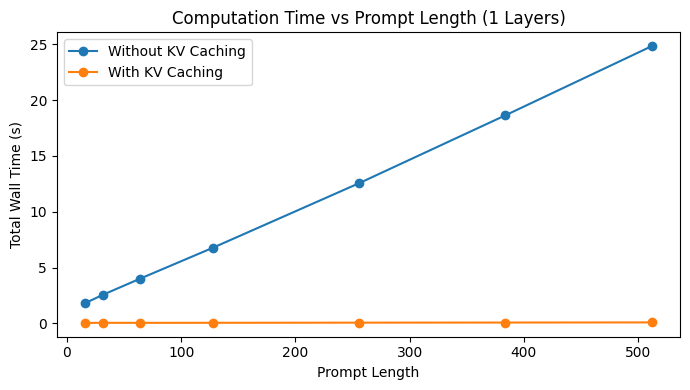


PromptLength | Cache(MB) | With Cache(s) | Without Cache(s) | Speedup
--------------------------------------------------
      16 |     0.13 |   0.046 |      1.819 |   39.56
      32 |     0.16 |   0.051 |      2.587 |   50.90
      64 |     0.22 |   0.049 |      4.005 |   81.15
     128 |     0.35 |   0.054 |      6.785 |  126.71
     256 |     0.60 |   0.067 |     12.566 |  187.96
     384 |     0.85 |   0.077 |     18.641 |  242.98
     512 |     1.10 |   0.088 |     24.831 |  280.91

=== Number of Layers Scaling ===

  layers=6: 2.1 MB, Wall time: 0.356s
  layers=12: 4.2 MB, Wall time: 0.724s
  layers=24: 8.3 MB, Wall time: 1.439s
  layers=48: 16.7 MB, Wall time: 2.863s


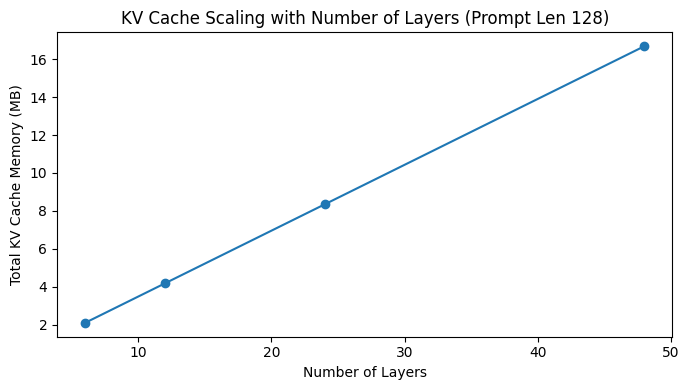

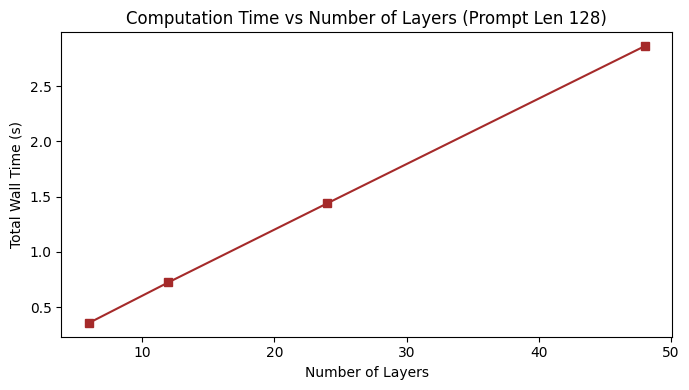


Layers | Cache(MB) | With KV Cache Wall Time (s)
----------------------------------------
     6 |     2.09 |                   0.356
    12 |     4.17 |                   0.724
    24 |     8.34 |                   1.439
    48 |    16.69 |                   2.863


In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt


def benchmark_prompt_length_scaling(prompt_lens, n_generations=50, d_model=512, n_heads=8, batch_size=1, layers=1):
    print("\n=== Prompt Length Scaling ===\n")
    cached_times = []
    uncached_times = []
    cache_sizes = []
    speedups = []

    for pl in prompt_lens:
        print(f"Prompt Length = {pl}")
        # Multiple layers: create stack of attention layers
        attn_layers_with_cache = [MultiHeadAttentionWithCache(d_model, n_heads, max_seq_len=pl+n_generations) for _ in range(layers)]
        attn_layers_without_cache = [MultiHeadAttentionWithCache(d_model, n_heads, max_seq_len=pl+n_generations) for _ in range(layers)]
        # Init caches
        for attn in attn_layers_with_cache:
            attn.init_cache(batch_size)
        prompt = np.random.randn(batch_size, pl, d_model)

        # With KV cache
        for attn in attn_layers_with_cache:
            _ = attn.forward(prompt, start_pos=0, use_cache=True)
        start_time = time.time()
        for i in range(n_generations):
            x = np.random.randn(batch_size, 1, d_model)
            for attn in attn_layers_with_cache:
                _ = attn.forward(x, start_pos=pl + i, use_cache=True)
        cached_time = time.time() - start_time
        cache_size = sum(attn.kv_cache.get_stats()['memory_usage_mb'] for attn in attn_layers_with_cache)

        # Without KV cache
        current_seq = prompt.copy()
        start_time = time.time()
        for i in range(n_generations):
            new_token = np.random.randn(batch_size, 1, d_model)
            current_seq = np.concatenate([current_seq, new_token], axis=1)
            for attn in attn_layers_without_cache:
                _ = attn.forward(current_seq, use_cache=False)
        uncached_time = time.time() - start_time

        speedup = uncached_time / cached_time if cached_time > 0 else float('inf')
        print(f"  With KV cache: {cached_time:.3f}s, Without: {uncached_time:.3f}s, Speedup: {speedup:.2f}x, Cache: {cache_size:.2f}MB")
        cached_times.append(cached_time)
        uncached_times.append(uncached_time)
        cache_sizes.append(cache_size)
        speedups.append(speedup)

    # Plots
    plt.figure(figsize=(7,4))
    plt.plot(prompt_lens, uncached_times, 'o-', label='Without KV Caching')
    plt.plot(prompt_lens, cached_times, 'o-', label='With KV Caching')
    plt.xlabel("Prompt Length")
    plt.ylabel("Total Wall Time (s)")
    plt.title(f"Computation Time vs Prompt Length ({layers} Layers)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nPromptLength | Cache(MB) | With Cache(s) | Without Cache(s) | Speedup")
    print("-"*50)
    for i, pl in enumerate(prompt_lens):
        print(f"{pl:8d} | {cache_sizes[i]:8.2f} | {cached_times[i]:7.3f} | {uncached_times[i]:10.3f} | {speedups[i]:7.2f}")

def benchmark_layer_scaling(num_layers_list, prompt_len=128, n_generations=50, d_model=512, n_heads=8, batch_size=1):
    print("\n=== Number of Layers Scaling ===\n")
    total_cache_sizes = []
    total_cached_times = []

    for layers in num_layers_list:
        attn_layers = [MultiHeadAttentionWithCache(d_model, n_heads, max_seq_len=prompt_len + n_generations) for _ in range(layers)]
        for attn in attn_layers:
            attn.init_cache(batch_size)
        prompt = np.random.randn(batch_size, prompt_len, d_model)
        for attn in attn_layers:
            _ = attn.forward(prompt, start_pos=0, use_cache=True)
        start_time = time.time()
        for i in range(n_generations):
            x = np.random.randn(batch_size, 1, d_model)
            for attn in attn_layers:
                _ = attn.forward(x, start_pos=prompt_len + i, use_cache=True)
        cached_time = time.time() - start_time
        total_mb = sum(attn.kv_cache.get_stats()['memory_usage_mb'] for attn in attn_layers)
        print(f"  layers={layers}: {total_mb:.1f} MB, Wall time: {cached_time:.3f}s")
        total_cache_sizes.append(total_mb)
        total_cached_times.append(cached_time)

    plt.figure(figsize=(7,4))
    plt.plot(num_layers_list, total_cache_sizes, 'o-')
    plt.xlabel("Number of Layers")
    plt.ylabel("Total KV Cache Memory (MB)")
    plt.title(f"KV Cache Scaling with Number of Layers (Prompt Len {prompt_len})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(num_layers_list, total_cached_times, 's-', color='brown')
    plt.xlabel("Number of Layers")
    plt.ylabel("Total Wall Time (s)")
    plt.title(f"Computation Time vs Number of Layers (Prompt Len {prompt_len})")
    plt.tight_layout()
    plt.show()

    print("\nLayers | Cache(MB) | With KV Cache Wall Time (s)")
    print("-"*40)
    for i, layers in enumerate(num_layers_list):
        print(f"{layers:6d} | {total_cache_sizes[i]:8.2f} | {total_cached_times[i]:23.3f}")

# ----- PARAMETERS -----
prompt_lens = [16, 32, 64, 128, 256, 384, 512]
num_layers_list = [6, 12, 24, 48]

# --- Run both analyses ---
benchmark_prompt_length_scaling(prompt_lens, n_generations=50, d_model=512, n_heads=8, batch_size=1, layers=1)
benchmark_layer_scaling(num_layers_list, prompt_len=128, n_generations=50, d_model=512, n_heads=8, batch_size=1)